In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# Data preparation

## CSL air quality data

In [26]:
csl_data = pd.read_csv("data/csl-data.csv")
csl_data['timestamp'] = pd.to_datetime(csl_data['timestamp'],unit='s')
csl_data = csl_data.drop(['minute', 'hour', 'day', 'month','year'], axis=1) #wrong timezone (BST)
data_cols = [col for col in csl_data.columns if 'AQI' not in col]
csl_data = csl_data[data_cols] #drop columns relating to AQI

#date and time with GMT  timezone
csl_data['month'] = csl_data.timestamp.dt.month
csl_data['day'] = csl_data.timestamp.dt.day
csl_data['hour'] = csl_data.timestamp.dt.hour
csl_data['year'] = csl_data.timestamp.dt.year
#group data by date+time to calculate hourly averages
csl_data = csl_data.groupby(['year', 'month', 'day', 'hour']).mean()
csl_data.reset_index(inplace=True)
csl_data['timestamp'] = pd.to_datetime(csl_data[['year', 'month', 'day', 'hour']])
csl_data = csl_data.set_index('timestamp')
csl_data.tail()

year  month  day  hour  CH4      CO  NH3       NO2  \
timestamp                                                                 
2020-08-13 12:00:00  2020      8   13    12  0.0  0.0600  0.0  0.005027   
2020-08-13 13:00:00  2020      8   13    13  0.0  0.0625  0.0  0.004920   
2020-08-13 14:00:00  2020      8   13    14  0.0  0.0675  0.0  0.004594   
2020-08-13 15:00:00  2020      8   13    15  0.0  0.0550  0.0  0.005903   
2020-08-13 16:00:00  2020      8   13    16  0.0  0.0500  0.0  0.005912   

                     PM1_0  PM2_5  PM10_0  eCO2  tVOC  vcc_volt  
timestamp                                                        
2020-08-13 12:00:00  20.75  35.00   43.00  -1.0  -1.0    3.3690  
2020-08-13 13:00:00  21.75  34.25   48.00  -1.0  -1.0    3.3715  
2020-08-13 14:00:00  17.00  26.75   30.25  -1.0  -1.0    3.3690  
2020-08-13 15:00:00  14.75  24.75   28.25  -1.0  -1.0    3.3715  
2020-08-13 16:00:00  18.50  31.00   36.00  -1.0  -1.0    3.3740

## City centre weather data

In [33]:
from datetime import timedelta

centre_data = pd.read_csv("data/cardiff-centre-data.csv")
data_cols = ['Date', 'Time', 'Modelled Wind Direction', 'Modelled Wind Speed', 'Modelled Temperature']
centre_data = centre_data[data_cols]
centre_data = centre_data.drop(centre_data.shape[0]-1) #drop last row, which is invalid
centre_data['Date'] = pd.to_datetime(centre_data['Date'])
def fix_centre_dates(row):
    if row.Time == '24:00:00':
        row.Time = '00:00:00'
        row.Date = row.Date + timedelta(days=1)
    return row
centre_data = centre_data.apply(fix_centre_dates, axis=1)
centre_data['Date'] = pd.to_datetime(centre_data['Date'].apply(lambda d: d.strftime('%Y-%m-%d'))+' '+centre_data['Time'])
centre_data = centre_data.drop(['Time'], axis=1)
centre_data.columns = ['Date', 'Wind_dir', 'Wind_spd', 'Temperature']
centre_data = centre_data.set_index('Date')
centre_data[centre_data.columns] = centre_data[centre_data.columns].apply(pd.to_numeric, errors='coerce')
centre_data.head()

Wind_dir  Wind_spd  Temperature
Date                                                
2020-06-23 01:00:00     210.0       2.7         10.7
2020-06-23 02:00:00     199.5       2.8         10.3
2020-06-23 03:00:00     209.8       3.4         10.7
2020-06-23 04:00:00     215.0       2.6         10.9
2020-06-23 05:00:00     195.7       1.9         10.8

## Merging the two datasets

In [36]:
full_data = csl_data.join(centre_data)
full_data = full_data.dropna()

full_data.head()

year  month  day  hour  CH4        CO    NH3       NO2  \
timestamp                                                                     
2020-06-23 11:00:00  2020      6   23    11  0.0  0.075000  0.005  0.001414   
2020-06-23 12:00:00  2020      6   23    12  0.0  0.076667  0.010  0.001275   
2020-06-23 13:00:00  2020      6   23    13  0.0  0.090000  0.010  0.000936   
2020-06-23 14:00:00  2020      6   23    14  0.0  0.110000  0.010  0.000719   
2020-06-23 15:00:00  2020      6   23    15  0.0  0.100000  0.010  0.000921   

                     PM1_0     PM2_5    PM10_0         eCO2    tVOC  vcc_volt  \
timestamp                                                                       
2020-06-23 11:00:00   0.50  4.000000  5.000000   706.000000   46.00  3.369000   
2020-06-23 12:00:00   2.00  2.666667  3.333333   877.333333   72.00  3.365667   
2020-06-23 13:00:00   2.50  3.500000  4.000000  1803.000000  213.50  3.366500   
2020-06-23 14:00:00   1.50  2.000000  2.250000  2311.500000  290.75  3.364000   
2020-06-23 15:00:00   1.25  3.250000  6.250000  1907.750000  229.25  3.366500   

                     Wind_dir  Wind_spd  Temperature  
timestamp                                             
2020-06-23 11:00:00     143.3       3.2         17.1  
2020-06-23 12:00:00     158.2       3.3         19.4  
2020-06-23 13:00:00     168.3       3.9         21.4  
2020-06-23 14:00:00     169.8       4.8         22.0  
2020-06-23 15:00:00     171.5       5.4         22.0

# Data analysis

## Temperature

Text(30.472196180555557, 0.5, 'Concentration (ppm)')

<Figure size 576x432 with 0 Axes>

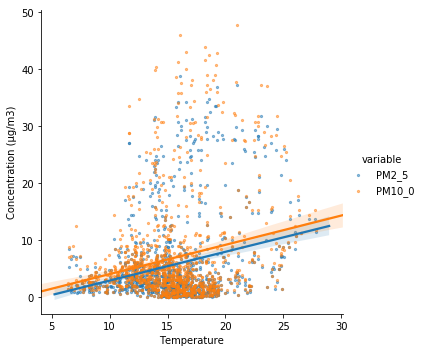

<Figure size 576x432 with 0 Axes>

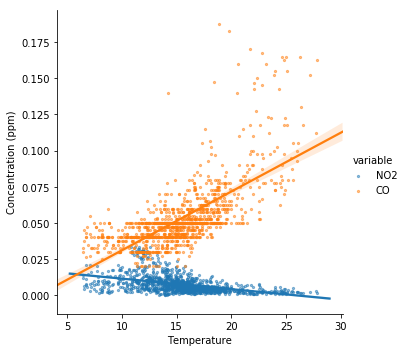

In [227]:
plt.figure(figsize=(8, 6))
long_data = full_data.melt(id_vars=['Temperature', 'Wind_spd', 'Wind_dir'],
                           value_vars=['PM2_5', 'PM10_0', 'NO2', 'CO'])

sns.lmplot(data=long_data[long_data.variable.isin(['PM10_0', 'PM2_5'])],
           x='Temperature', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5})
plt.ylabel('Concentration (μg/m3)')
plt.figure(figsize=(8, 6))
sns.lmplot(data=long_data[long_data.variable.isin(['NO2', 'CO'])],
           x='Temperature', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5})
plt.ylabel('Concentration (ppm)')

There appears to be a slight positive correlation between particulate matter levels and temperature. However, there is a stronger positive correlation with carbon monoxide and a negative correlation with nitrogen dioxide.

It is difficult to know whether there is actually causation or whether there is a different factor linking them together. For example, it may be that lockdown has eased and caused the air pollution from road traffic to increase, coincidentally at the same time as the weather became warmer in summer. We will have to wait for more data to see if this is the case.

## Wind speed

Text(30.472196180555557, 0.5, 'Concentration (ppm)')

<Figure size 288x360 with 0 Axes>

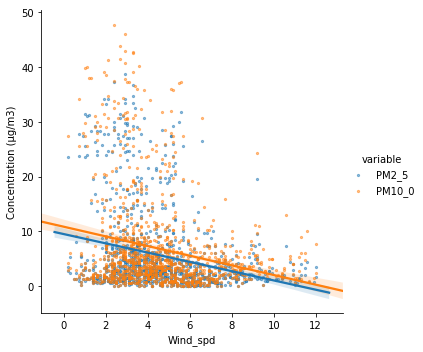

<Figure size 288x360 with 0 Axes>

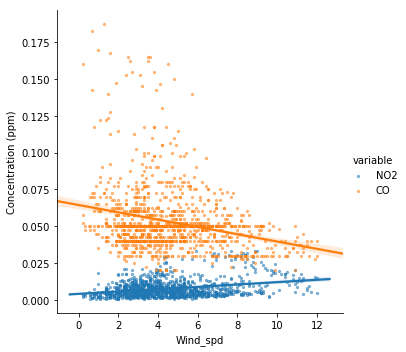

In [224]:
plt.figure(figsize=(8, 6))
sns.lmplot(data=long_data[long_data.variable.isin(['PM10_0', 'PM2_5'])],
           x='Wind_spd', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5})
plt.ylabel('Concentration (μg/m3)')
plt.figure(figsize=(8, 6))
sns.lmplot(data=long_data[long_data.variable.isin(['NO2', 'CO'])],
           x='Wind_spd', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5})
plt.ylabel('Concentration (ppm)')

The levels of particulate matter and carbon monoxide seem to decrease with wind speed. This would make sense because when there is wind the pollutants are blown away instead of building up in one area.

However, the levels of nitrogen dioxide increase with wind speed. It may be that there are higher emissions of NO2 a short distance from the school and the wind blows the gas towards the school.

## Wind direction

(0, 360)

<Figure size 576x432 with 0 Axes>

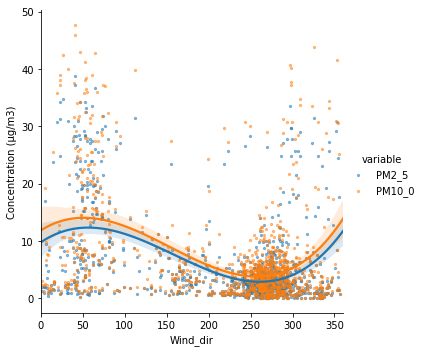

<Figure size 576x432 with 0 Axes>

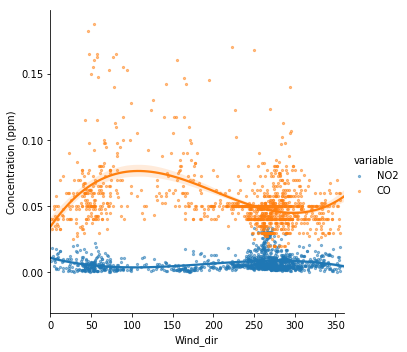

In [226]:
plt.figure(figsize=(8, 6))
sns.lmplot(data=long_data[long_data.variable.isin(['PM10_0', 'PM2_5'])],
           x='Wind_dir', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5}, order=3)
plt.ylabel('Concentration (μg/m3)')
plt.xlim(0, 360)
plt.figure(figsize=(8, 6))
sns.lmplot(data=long_data[long_data.variable.isin(['NO2', 'CO'])],
           x='Wind_dir', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5}, order=3)
plt.ylabel('Concentration (ppm)')
plt.xlim(0, 360)

The wind direction seems to affect the pollutant levels slightly, with particulate matter levels tending to be higher when wind is coming from the North-East and carbon monoxide levels higher when wind is coming from the East and South-East. This can be visualised more easily on a radial compass diagram.

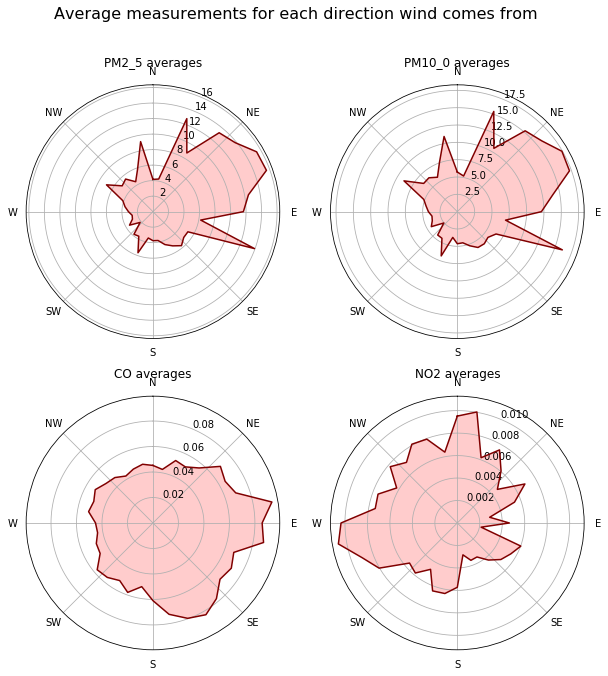

In [228]:
from math import radians

full_data['Wind_dir_round'] = full_data['Wind_dir'].round(-1)
averages_for_wind_dir = full_data.groupby('Wind_dir_round').mean()
#0 and 360 degrees refer to the same direction, so should be the same
averages_for_wind_dir.loc[0] = (averages_for_wind_dir.loc[0] + averages_for_wind_dir.loc[360]) / 2
averages_for_wind_dir.loc[360] = averages_for_wind_dir.loc[0]

f = plt.figure(figsize=(10,10.5))
f.tight_layout()
f.suptitle("Average measurements for each direction wind comes from", fontsize=16)

variables = ['PM2_5', 'PM10_0', 'CO', 'NO2']

for i in range(4):
    ax = f.add_subplot(221+i, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    ax.plot([radians(x) for x in averages_for_wind_dir.index.values], 
    averages_for_wind_dir[variables[i]].values, color='maroon')
    ax.title.set_text(variables[i]+' averages')
    plt.fill_between([radians(x) for x in averages_for_wind_dir.index.values],
                     averages_for_wind_dir[variables[i]].values, 0,
                     facecolor="red", alpha=0.2)